# Shopping Item Recommendation with GBDT and LR


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
import datetime
# GBDT
    # features, continus and categorical variables
# LR
    #  

### Read data

In [73]:
df = pd.read_csv('./data/shopping-items/data.csv', sep='\t')
print(df.head(2))


               item_id                       item_category_list  \
0  2744506471184009586  7908382889764677758;7258015885215914736   
1  9148952645395028291  7908382889764677758;5755694407684602296   

                                  item_property_list        item_brand_id  \
0  5131280576272319091;2636395404473730413;751580...  7838285046767229711   
1  5131280576272319091;6434796455031995313;914848...  4609398715869550725   

          item_city_id  item_price_level  item_sales_level  \
0  5918626470536001929                 4                11   
1  7322157373578955368                 7                11   

   item_collected_level  item_pv_level              user_id  ...  \
0                    10             17   545400486120000430  ...   
1                    12             18  2288811001379435459  ...   

                           predict_category_property              shop_id  \
0  7258015885215914736:9148482949976129397;509660...  7298587034305908007   
1  57556944076846022

### Analyze data

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55933 entries, 0 to 55932
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_id                    55933 non-null  int64  
 1   item_category_list         55933 non-null  object 
 2   item_property_list         55933 non-null  object 
 3   item_brand_id              55933 non-null  int64  
 4   item_city_id               55933 non-null  int64  
 5   item_price_level           55933 non-null  int64  
 6   item_sales_level           55933 non-null  int64  
 7   item_collected_level       55933 non-null  int64  
 8   item_pv_level              55933 non-null  int64  
 9   user_id                    55933 non-null  int64  
 10  user_gender_id             55933 non-null  int64  
 11  user_age_level             55933 non-null  int64  
 12  user_occupation_id         55933 non-null  int64  
 13  user_star_level            55933 non-null  int

In [75]:
df.shape

(55933, 27)

<Axes: xlabel='is_click'>

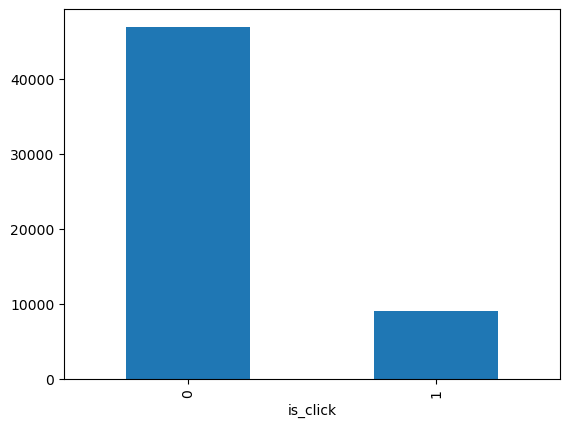

In [76]:
df['is_click'].value_counts().plot(kind='bar')

In [77]:


dtime = pd.DataFrame(df['date'].unique())
dtime['weekday'] = dtime.iloc[:,0].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date().weekday())
dtime

,0,weekday
0,2018-09-18,1
1,2018-09-19,2
2,2018-09-20,3
3,2018-09-21,4
4,2018-09-22,5
5,2018-09-23,6
6,2018-09-24,0


In [78]:
df.groupby('date')['is_click'].mean()

date
2018-09-18    0.168404
2018-09-19    0.167567
2018-09-20    0.167045
2018-09-21    0.163729
2018-09-22    0.162794
2018-09-23    0.148233
2018-09-24    0.146213
Name: is_click, dtype: float64

In [79]:
print('item_brand_id ',df['item_brand_id'].unique().size)
print('item_id ',df['item_id'].unique().size)
print('item_price_level ',df['item_price_level'].unique().size)


item_brand_id  1466
item_id  5702
item_price_level  12


In [80]:
df.groupby('item_id')['is_click'].mean().head().reset_index()


,item_id,is_click
0,696490723789804,0.333333
1,1097631460775571,0.166667
2,1637165183538885,0.000000
3,4255654217639344,0.000000
4,6536469184064787,0.000000


### Train test split

In [81]:
df_train = df[df['date']!='2018-09-24']
df_test = df[df['date']=='2018-09-24']

### Transform data

In [82]:
CATEGORICAL_FEATURES = ['item_city_id','user_gender_id','user_occupation_id']
CONTINUOUS_FEATURES = ['item_price_level', 'item_sales_level', 'item_collected_level','item_pv_level', 'user_age_level', 'user_star_level', 'shop_review_num_level', 'shop_review_positive_rate',
                       'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
VECTOR_FEATURES = ['item_category_list']

### Train GBDT model

In [83]:
def get_continuous_features(data):
    return data[CONTINUOUS_FEATURES]

def get_labels(data):
    return data['is_click']

def get_categorical_features(data):
    enc = OneHotEncoder()
    category_data = data[CATEGORICAL_FEATURES]
    enc.fit(category_data)
    return enc.transform(category_data).toarray()

def get_vector_features(train_data, test_data):
    train_fea , test_feat = None, None    
    for key in VECTOR_FEATURES:        
        c_vector = CountVectorizer()
        c_vector.fit(pd.concat([train_data[key], test_data[key]]))
        if train_fea is None:
            train_fea = c_vector.transform(train_data[key]).toarray()
            test_fea = c_vector.transform(test_data[key]).toarray()
        else:
            train_fea = np.stack([train_fea,c_vector.transform(train_data[key]).toarray()])
            test_fea = np.stack([test_fea,c_vector.transform(test_data[key]).toarray()])
    return train_fea, test_fea

y_train_label = get_labels(df_train)
X_train_gbdt = get_continuous_features(df_train)

y_test_label = get_labels(df_test)
X_test_gbdt = get_continuous_features(df_test)

x_train_category = get_categorical_features(df_train)
# x_test_category = get_categorical_features(df_test)

X_train_vector, X_test_vector = get_vector_features(df_train, df_test)

In [84]:
gbdt = GradientBoostingClassifier(n_estimators=50, max_depth=4, random_state=0, verbose=1)
gbdt.fit(X_train_gbdt, y_train_label)

      Iter       Train Loss   Remaining Time 
         1           0.8821            4.00s
         2           0.8756            3.74s
         3           0.8704            3.61s
         4           0.8660            3.49s
         5           0.8627            3.39s
         6           0.8595            3.30s
         7           0.8568            3.21s
         8           0.8546            3.15s
         9           0.8524            3.09s
        10           0.8505            3.01s
        20           0.8382            2.24s
        30           0.8307            1.50s
        40           0.8258            0.76s
        50           0.8217            0.00s


GradientBoostingClassifier(max_depth=4, n_estimators=50, random_state=0,
                           verbose=1)

In [85]:
indexs = gbdt.apply(X_train_gbdt) # leave indexes
indexs_train = np.squeeze(indexs)
oneHotEncoder = OneHotEncoder()
oneHotEncoder.fit(indexs_train)
indexs_train_one_hot = oneHotEncoder.transform(indexs_train).toarray()
print(indexs_train_one_hot.shape)

# indexs_t = gbdt.apply(X_test_gbdt) # leave indexes
# indexs_test = np.squeeze(indexs_t)
# oneHotEncoder.fit(indexs_test)
# indexs_test_one_hot = oneHotEncoder.transform(indexs_test)
# print(indexs_test_one_hot.shape)

c:\Users\miche\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


(49292, 797)


### Train logistic regression model

In [86]:
# feed continuous features, categorical features and vector features into the logistic regression model
X_train_lr = np.hstack((X_train_vector, x_train_category, indexs_train_one_hot))
logisticModel = LogisticRegression(C=100, max_iter=50, n_jobs=8)
logisticModel.fit(X_train_lr, y_train_label)

LogisticRegression(C=100, max_iter=50, n_jobs=8)

### Evaluate model

In [88]:
prob = logisticModel.predict_proba(X_train_lr)
roc_auc_score(y_train_label, prob[:,1])

0.7195713213418993